In [19]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import pandas as pd
from shapely import wkt
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon


In [32]:
# read a polygon in the below format
def read_polygon(filename):
    ''' input file format:
    segment {x1} {y1} {x2} {y2} (optionally)    
    {x1}  {y1}
    {x2}  {y2}
     ...
    {xn}  {yn}
    .... '''
    polygon = list()
    segment = None
    with open(filename, 'r') as f: # open in read-only mode
        lines = f.readlines()
        start_idx = 0
        first_line = lines[0].split()
        if first_line[0] == "segment":
            segment = [ [float(first_line[1]), float(first_line[2])], [float(first_line[3]), float(first_line[4])] ]
            start_idx = 1
        for line in lines[start_idx:]:
            if len(line.split()) != 2:
                break
            x = line.split()[0]
            y = line.split()[1]
            polygon.append((float(x), float(y)))
    # polygon.append(polygon[0]) # to "close" the polygon line
    return polygon, segment

# # Read a grid of single polygon in each cell
# # setting cell type to None
# def read_simple_grid(filename):
#     ''' input file format:
#     {x1}  {y1}
#     {x2}  {y2}
#      ...
#     {xn}  {yn}
#     poly {i} {j}
#     {x1'}  {y1'}
#     {x2'}  {y2'}
#      ...
#     {xn'}  {yn'}
#     poly {i} {j}
#     cell 
#     .... '''
#     polygon = []
#     grid = {}
#     i=j=0
#     with open(filename, 'r') as f: 
#         lines = f.readlines()
#         no_of_lines = len(lines)
#         line_idx = 0
#         while (line_idx < no_of_lines):
#             line = lines[line_idx]
#             splited_lines = line.split()
#             if len(splited_lines) == 3:
#                 i = int(line.split()[1])
#                 j = int(line.split()[2])
#                 grid[(i,j)] = {"polygon": polygon, "cell_type": None}
#                 polygon = []
#             elif len(splited_lines) == 2:
#                 x = float(line.split()[0])
#                 y = float(line.split()[1])
#                 polygon.append((x, y))
#             else:
#                 print(line)
#                 print('Error')
#                 break

#             line_idx += 1
            
#     return grid

# Read a grid of multi/single polygon in each cell 
# without cell types
def read_grid_without_cell_types(filename):
    ''' input file format:
    {x1}  {y1}
    {x2}  {y2}
     ...
    {xn}  {yn}
    poly 
    {x1'}  {y1'}
    {x2'}  {y2'}
     ...
    {xn'}  {yn'}
    poly 
    cell {i} {j}
    .... '''
    polygons = []
    polygon = []
    grid = {}
    i=j=0
    with open(filename, 'r') as f: # open in read-only mode
        lines = f.readlines()
        no_of_lines = len(lines)
        line_idx = 0
        while (line_idx < no_of_lines):
            line = lines[line_idx]
            splited_lines = line.split()
            
            if len(splited_lines) == 3:
                i = int(line.split()[1])
                j = int(line.split()[2])
    
                grid[(i,j)] = {"vertices_vectors": polygons, "cell_type": None}
                polygons = []
                polygon = []
            elif len(splited_lines) == 2:
                x = float(line.split()[0])
                y = float(line.split()[1])
                polygon.append((x, y))
            elif len(splited_lines) == 1:
                polygons.append(polygon)
                polygon = []
            else:
                print(line)
                print('Error')
                break

            line_idx += 1
            
    return grid

# Read a grid of multi/single polygon in each cell 
# including cell types
def read_grid(filename):
    ''' input file format:
    {x1}  {y1}
    {x2}  {y2}
     ...
    {xn}  {yn}
    poly 
    {x1'}  {y1'}
    {x2'}  {y2'}
     ...
    {xn'}  {yn'}
    poly 
    cell {i} {j}
    {cell_type}
    .... '''
    polygon = []
    polygons = []
    grid = {}
    i=j=0
    with open(filename, 'r') as f: # open in read-only mode
        lines = f.readlines()
        no_of_lines = len(lines)
        line_idx = 0
        while (line_idx < no_of_lines):
            line = lines[line_idx]
            splited_lines = line.split()

            if len(splited_lines) == 3:
                i = int(line.split()[1])
                j = int(line.split()[2])

                line_idx += 1
                cell_type = lines[line_idx].split()[0]
                grid[(i,j)] = {"polygons": polygons, "cell_type": cell_type}
                polygons = []
                polygon = []
            elif len(splited_lines) == 2:
                x = float(line.split()[0])
                y = float(line.split()[1])
                polygon.append((x, y))
            elif len(splited_lines) == 1:
                polygons.append(polygon)
                polygon = []
            else:
                print(line)
                print('Error')
                break

            line_idx += 1
            
    return grid

# plot a polygon and a segment if provided
def plot_polygon(polygon, segment=None, figsize=(6, 4)):
    plt.figure(figsize=figsize)
    plt.rcParams["figure.autolayout"] = True
    plt.grid()
    
    x, y = zip(*polygon)
    num_points = len(polygon)
    colors = plt.cm.viridis(np.linspace(0, 1, num_points))

    for i in range(num_points - 1):
        plt.plot([x[i], x[i + 1]], [y[i], y[i + 1]], marker='o', color=colors[0])
    
    if segment:
        plt.plot([segment[0][0], segment[1][0]], [segment[0][1], segment[1][1]], marker='.', color='red', linewidth=5)
    
    plt.show()

# def plot_grid(grid, cell_type_to_color):
#     fig, ax = plt.subplots(figsize=(12, 12))  # Adjust width and height as needed

#     # Plot each cell
#     for (i, j), vertices_cell_type in grid.items():
#         vertices = vertices_cell_type['polygon']
#         cell_type = vertices_cell_type['cell_type']
#         # print(i, j, len(vertices), cell_type)
#         # Extract vertices for the polygon
#         if vertices:
#             x, y = zip(*vertices)
#             # Determine color by coordinate sum
#             color = cell_type_to_color[cell_type]
#             ax.fill(x, y, color, edgecolor='black', alpha=0.3)
#             ax.scatter(x, y, color='black', )


#     ax.set_aspect('equal')
#     # ax.grid(True, which='both', linestyle='--', linewidth=0.5)
#     plt.show()    
    
# plot a grid of polygons in the cells 
# with color in each cell depending on the type
# of the cell for which we use the map cell_type_to_color
def plot_grid(grid, cell_type_to_color, figsize=(8,6)):
    fig, ax = plt.subplots(figsize=figsize)  # Adjust width and height as needed

    # Plot each cell
    for (i, j), vertices_vectors_cell_type in grid.items():
        vertices_vectors = vertices_vectors_cell_type['polygons']
        cell_type = vertices_vectors_cell_type['cell_type']
        if vertices_vectors:
            # Determine color by coordinate sum
            # color = 'blue' if (i + j) % 2 == 0 else 'red'
            color = cell_type_to_color[cell_type]
            # color = 'blue' if i  % 2 == 0 else 'red'
            for vertices in vertices_vectors:
                x, y = zip(*vertices)
                ax.fill(x, y, color, edgecolor='black', alpha=0.3)
                # Plot the vertices as points
                ax.scatter(x, y, color='black', s=10)

    # ax.set_aspect('equal')
    plt.axis('off')
    # ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

# # plot a grid of polygons in the cells 
# # with different color between neighboors cells
# def plot_simple_grid(grid):
#     fig, ax = plt.subplots(figsize=(10, 8))  # Adjust width and height as needed

#     # Plot each cell
#     for (i, j), vertices_cell_type in grid.items():
#         vertices = vertices_cell_type['polygon']
#         if vertices:
#             x, y = zip(*vertices)
#             # Determine color by coordinate sum
#             color = 'blue' if (i + j) % 2 == 0 else 'red'
#             ax.fill(x, y, color, edgecolor='black', alpha=0.3)
#             # Plot the vertices as points
#             ax.scatter(x, y, color='black')

#     ax.set_aspect('equal')
#     # ax.grid(True, which='both', linestyle='--', linewidth=0.5)
#     plt.show()

# plot a grid of MULTIpolygons in the cells 
# with different color between neighboors cells
def plot_grid_without_cell_type(grid, figsize=(8,6)):
    fig, ax = plt.subplots(figsize=figsize)  # Adjust width and height as needed

    # Plot each cell
    for (i, j), vertices_vectors_cell_type in grid.items():
        vertices_vectors = vertices_vectors_cell_type['vertices_vectors']
        # Extract vertices for the polygon
        if vertices_vectors:
            
            # Determine color by coordinate sum
            color = 'blue' if (i + j) % 2 == 0 else 'red'
            # color = 'blue' if i  % 2 == 0 else 'red'
            for vertices in vertices_vectors:
                x, y = zip(*vertices)
                ax.fill(x, y, color, edgecolor='black', alpha=0.3)
                # Plot the vertices as points
                ax.scatter(x, y, color='black')

    # ax.set_aspect('equal')
    # ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()


def find_files(directory="./", prefix="grid"):
    files = []
    pattern = os.path.join(directory, f"{prefix}*")
    for filename in glob.glob(pattern):
        files.append(filename)

    return files

def polygon_area(vertices):
    n = len(vertices)
    area = 0.0
    
    for i in range(n-1):
        x1, y1 = vertices[i]
        x2, y2 = vertices[(i + 1) % n]
        print(f"({x1}, {y1}) - ({x2}, {y2}): {x1 * y2 - y1 * x2}")
        area += x1 * y2 - y1 * x2
    
    return abs(area) / 2.0

def cross_product(p1, p2, p3):
    return (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0])

def is_polygon_cw(vertices):
    sum = 0
    n = len(vertices)
    for i in range(n):
        p1 = vertices[i]
        p2 = vertices[(i + 1) % n]
        sum += (p2[0] - p1[0]) * (p2[1] + p1[1])
    return sum > 0


In [20]:
in_file_path = "error_poly.txt"
data = pd.read_csv(in_file_path, names=['WKT'])
geo_gdf = gpd.GeoDataFrame(data, geometry=data['WKT'].apply(wkt.loads))

In [30]:
def is_clockwise(polygon):
    # Extract the exterior coordinates of the polygon
    coords = list(polygon.exterior.coords)
    # Calculate the signed area
    area = 0.0
    for i in range(len(coords) - 1):
        x1, y1 = coords[i]
        x2, y2 = coords[i + 1]
        area += (x2 - x1) * (y2 + y1)
    # Return True if the polygon is clockwise, False if counterclockwise
    return area > 0
# Function to check if a geometry is a polygon without holes
def is_simple_polygon(geom):
    if isinstance(geom, Polygon):
        return not geom.interiors
    elif isinstance(geom, MultiPolygon):
        return all(not poly.interiors for poly in geom)
    return False

# Filter polygons and multipolygons without holes
geo_gdf['is_simple'] = geo_gdf['geometry'].apply(is_simple_polygon)
geo_gdf['is_valid'] = geo_gdf['geometry'].apply(lambda geom: geom.is_valid)

# Apply the function to each geometry and add a new column 'is_cw'
geo_gdf['is_cw'] = geo_gdf['geometry'].apply(is_clockwise)
display(geo_gdf.head())

,WKT,geometry,is_simple,is_cw,is_valid
0,"POLYGON ((-95.870899 46.345009,-95.870807 46.3...","POLYGON ((-95.87090 46.34501, -95.87081 46.345...",True,True,True


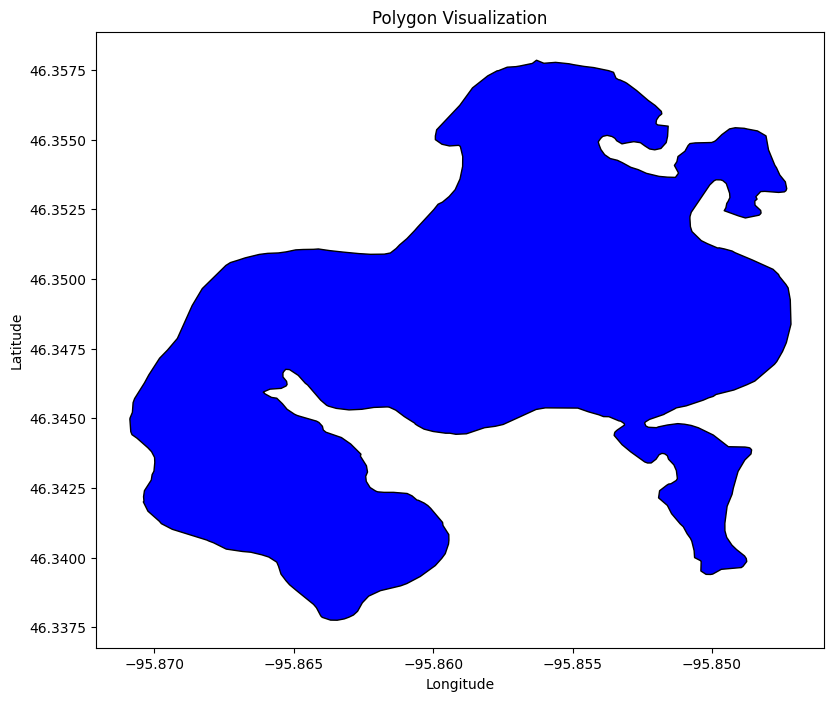

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))  # Larger figure size
geo_gdf.plot(ax=ax, color='blue', edgecolor='black')

plt.title('Polygon Visualization')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [5]:
cell_type_to_color = {
    "FULL": "#FF0000",
    "STRONG": "#FFDD44",
    "WEAK": "#ADD8E6",
    "NULL": "red"
}

In [9]:
for i_j, cell_info in grid.items():
    if cell_info['cell_type'] == "NULL":
        print(i_j) 
        print(cell_info['polygons'])

(0, 8)
[[(4.8125, 7.3125), (4.8125, 7.0), (4.5, 7.0), (4.5, 7.3125), (4.8125, 7.3125)]]


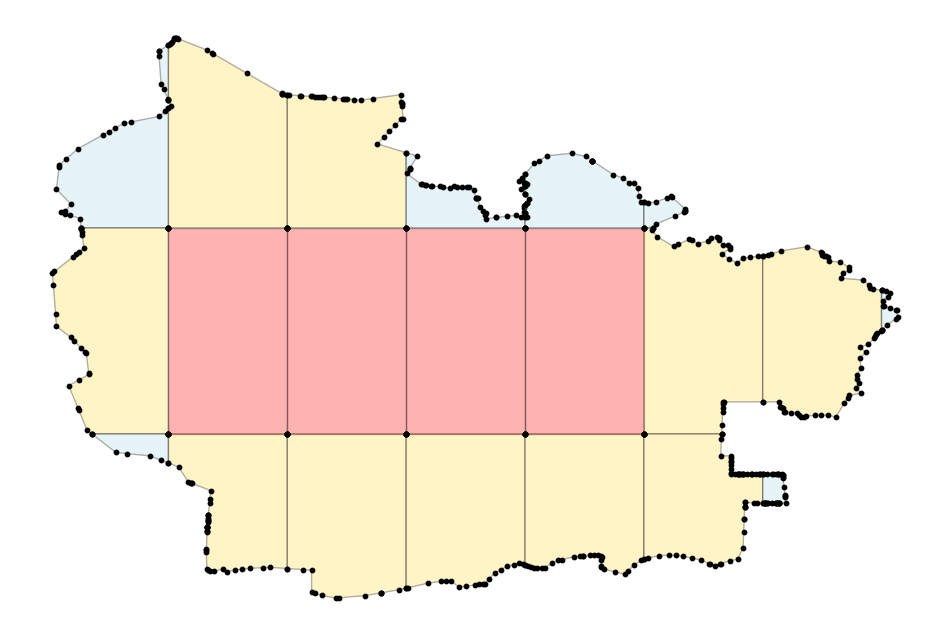

In [8]:
error = "error.txt"
output = "output.txt"
grid_f_name = "grid.txt"
test = "../../build/wrong_clip.txt"
grid = read_grid(grid_f_name)
plot_grid(grid, cell_type_to_color, (12,8))

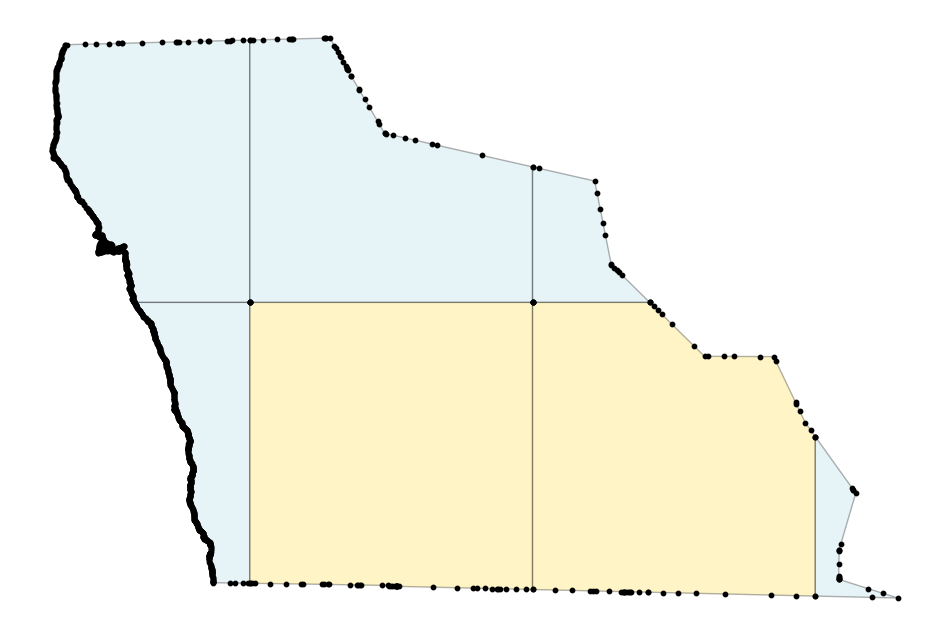

In [7]:
error = "error.txt"
output = "output.txt"
grid_f_name = "grid.txt"
test = "../../build/wrong_clip.txt"
grid = read_grid(grid_f_name)
plot_grid(grid, cell_type_to_color, (12,8))

In [5]:
files = find_files()

In [5]:
# for file in files:
#     grid = read_grid(file)
#     plot_grid(grid)

In [7]:
# simple_grid2 = read_simple_grid("test2.txt")
# plot_simple_grid(simple_grid2)

In [10]:
# grid_area = 0
# for vertices in grid.values():
#     if vertices:
#         print(vertices)
#         print(polygon_area(vertices))
#         grid_area+=polygon_area(vertices)
# grid_area

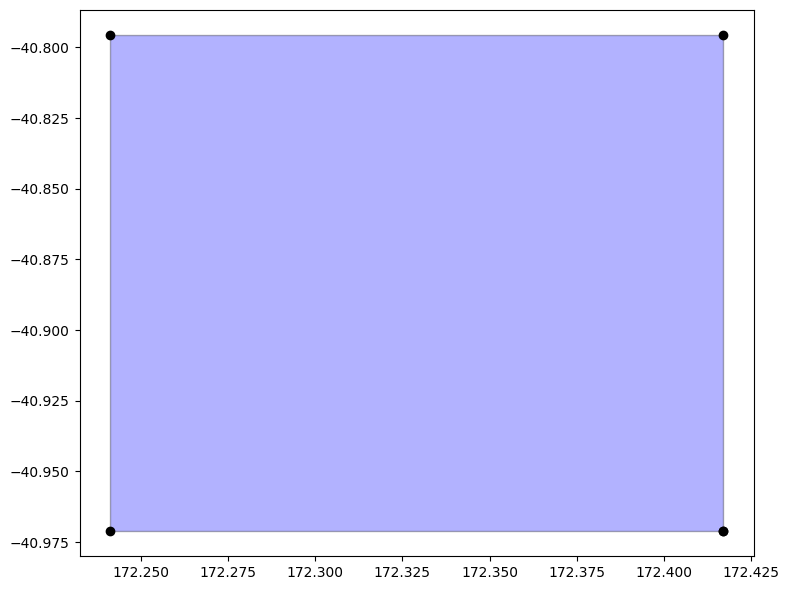

In [35]:
col_error = read_vectors_grid(test)
plot_point_vectors(col_error)

In [7]:
inter_grid = read_vectors_grid("inter_result.txt")
plot_point_vectors(inter_grid)

FileNotFoundError: [Errno 2] No such file or directory: 'inter_result.txt'

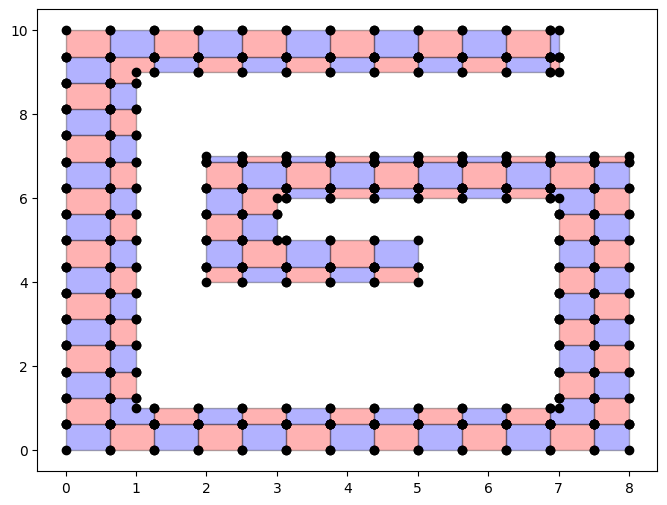

In [31]:
grid = read_vectors_grid("result.txt")
plot_point_vectors(grid)

In [36]:
poly, segment = read_polygon("error.txt")
plot_polygon(poly, segment, figsize=(6,4))

grid = read_vectors_grid("inter_result.txt")
plot_point_vectors(grid, figsize=(6,4))

FileNotFoundError: [Errno 2] No such file or directory: 'error.txt'

In [30]:
print(segment)

[[8.75, 8.75], [9.0625, 8.75]]


In [34]:
segment

[[-95.870119, 46.343819], [-95.870119, 46.343819]]

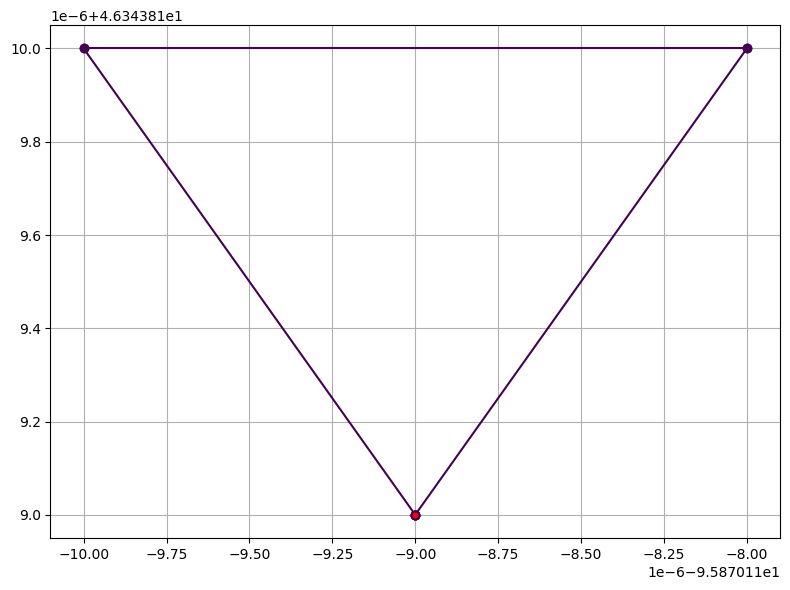

In [33]:
poly, segment = read_polygon("weiler_error.txt")
plot_polygon(poly, segment, figsize=(8,6))

# grid = read_vectors_grid("result.txt")
# plot_point_vectors(grid)

In [8]:
if is_polygon_cw(poly):
    print("The polygon is in clockwise order.")
else:
    print("The polygon is in counterclockwise order.")

The polygon is in counterclockwise order.


In [12]:
def is_clockwise(coords):
    # Extract the exterior coordinates of the polygon
    # Calculate the signed area
    area = 0.0
    for i in range(len(coords) - 1):
        x1, y1 = coords[i]
        x2, y2 = coords[i + 1]
        area += (x2 - x1) * (y2 + y1)
    # Return True if the polygon is clockwise, False if counterclockwise
    return area > 0

# Apply the function to each geometry and add a new column 'is_cw'
is_clockwise(poly)

False

In [13]:
len(poly)

71

([(2.0, 9.0), (7.0, 8.0), (4.0, 7.5), (7.0, 7.0), (2.0, 7.0), (2.0, 9.0)], None)


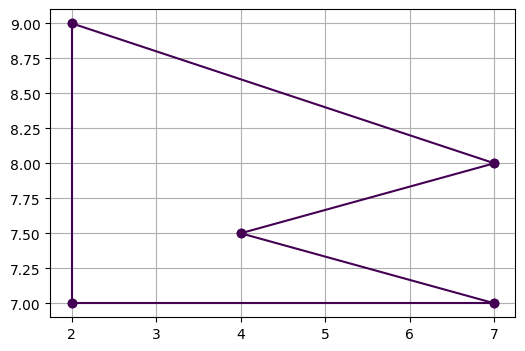

In [6]:
poly = read_polygon("polygon.txt")
print(poly)
plot_polygon(poly[0], figsize=(6,4))

([(2.0, 9.0), (7.0, 8.0), (4.0, 7.5), (7.0, 7.0), (4.0, 4.0), (7.0, 6.0), (8.0, 4.0), (8.5, 6.0), (9.0, 4.0), (2.0, 2.0), (2.0, 9.0)], None)


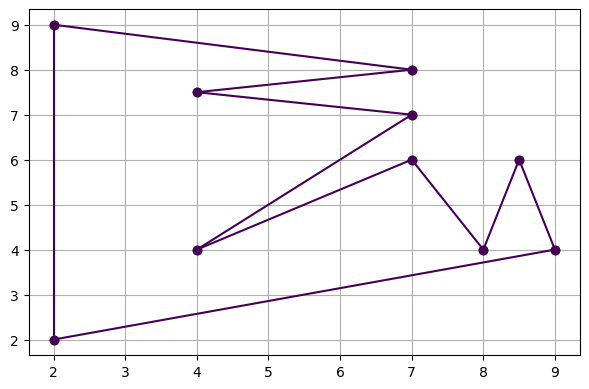

In [29]:
poly = read_polygon("../../build/left_poly.txt")
print(poly)
plot_polygon(poly[0], figsize=(6,4))

In [19]:
len(poly[0])

71

In [20]:
is_clockwise(poly[0])

False